# General description of the file

This file contains the necessary codes to generate solutions for the "FoodNet System" project by the group RJDados, including some visualization tools (tables and maps) and the optimization model to obtain suggestions for the locations of food logistics hubs. This work was developed in the context of the UN Datathon 2023 by <b>José Hudson de Oliveira Guimarães Junior</b>, <b>Madalena Alves dos Santos</b> and <b>Pedro Paixão Borges</b>. More details about the project can be found in the StoryMap provided along this Notebook.

# Importing necessary packages

In [50]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import fiona
import os
import numpy as np
import matplotlib.colors as mcolors
from shapely.geometry import LineString
from scipy.spatial import distance_matrix
from sklearn.neighbors import DistanceMetric
from shapely import wkt
from ast import literal_eval
from math import radians
import plotly.express as py
import pulp
import zipfile
import glob
import folium
from folium import Choropleth, GeoJson
import plotly.express as px
from ipywidgets import interact, widgets
from scipy.spatial.distance import cdist
from math import radians
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import widgets, Output, VBox, HBox, Button
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus

# Loading and transforming data

In [156]:
cons_ref_rj = pd.read_csv('./Data/Processed_Data/cons_ref_rj.csv')
imc_rj = pd.read_csv('./Data/Processed_Data/imc_rj.csv')
muns_demand_time_rj = pd.read_csv('./Data/Processed_Data/muns_demand_time.csv')
geodata_rj = pd.read_csv("./Data/geodata_rj.csv")

# Tratamentos básicos no , convertendo DataFrame para GeoDataFrame
limits_rj = geodata_rj['geometry']
geodata_rj['geometry'] = geodata_rj['geometry'].apply(wkt.loads)
geodata_rj['centroid'] = gpd.GeoSeries.from_wkt(geodata_rj['centroid'])
geodata_rj = gpd.GeoDataFrame(geodata_rj, crs='epsg:4326')
geodata_rj['CD_MUN'] = geodata_rj['CD_MUN'].astype(str)

muns_demand_time_rj['geometry'] = muns_demand_time_rj['geometry'].apply(wkt.loads)
# muns_demand_time_rj['centroid'] = gpd.GeoSeries.from_wkt(muns_demand_time_rj['centroid'])
muns_demand_time_rj = gpd.GeoDataFrame(muns_demand_time_rj, crs='epsg:4326')
muns_demand_time_rj['cod_mun_ibge'] = muns_demand_time_rj['cod_mun_ibge'].astype(str)
muns_demand_time_rj.head()

,Unnamed: 0,cod_mun_completo,cod_mun_ibge,nome_mun,cadunico_tot_pes,cadunico_tot_pes_rpc_ate_meio_sm,cadunico_tot_pes_pob,cadunico_tot_pes_ext_pob,cadunico_tot_pes_pob_e_ext_pob,cadunico_tot_fam,cadunico_tot_fam_rpc_ate_meio_sm,cadunico_tot_fam_pob,cadunico_tot_fam_ext_pob,cadunico_tot_fam_pob_e_ext_pob,mes,ano,geometry
0,0,3300100,330010,Angra dos Reis,44222.0,42615.0,13134.0,21549.0,34683.0,12919,12187.0,3400.0,6383.0,9783.0,12,2012,"MULTIPOLYGON (((-44.51649 -23.03589, -44.51633..."
1,1,3300100,330010,Angra dos Reis,42727.0,41257.0,13051.0,20831.0,33882.0,12356,11692.0,3364.0,6098.0,9462.0,11,2012,"MULTIPOLYGON (((-44.51649 -23.03589, -44.51633..."
2,2,3300100,330010,Angra dos Reis,41559.0,40161.0,13002.0,19991.0,32993.0,11950,11320.0,3343.0,5822.0,9165.0,10,2012,"MULTIPOLYGON (((-44.51649 -23.03589, -44.51633..."
3,3,3300100,330010,Angra dos Reis,40641.0,39327.0,13189.0,19285.0,32474.0,11599,11007.0,3384.0,5574.0,8958.0,9,2012,"MULTIPOLYGON (((-44.51649 -23.03589, -44.51633..."
4,4,3300100,330010,Angra dos Reis,39324.0,38103.0,13156.0,18384.0,31540.0,11110,10562.0,3379.0,5239.0,8618.0,8,2012,"MULTIPOLYGON (((-44.51649 -23.03589, -44.51633..."


# Map of the state of Rio de Janeiro and centroids representing every city

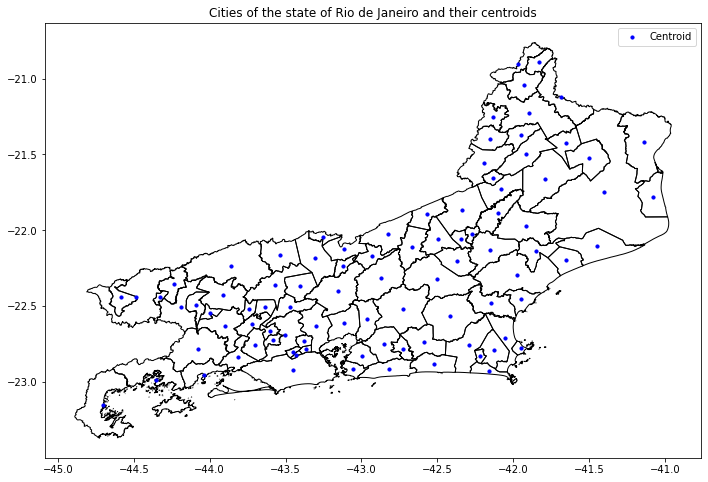

In [52]:
# Create a matplotlib figure and axis object
fig, ax = plt.subplots(figsize=(22.5, 8))

# Get centroid
centroids = geodata_rj['centroid']

# Create a new geopandas dataframe for the centroids
gdf_centroids = gpd.GeoDataFrame({'geometry': centroids})

geodata_rj.plot(ax=ax, facecolor='none', edgecolor='black')
gdf_centroids.plot(ax=ax, color='blue', markersize=10, label="Centroid")
ax.title.set_text("Cities of the state of Rio de Janeiro and their centroids")
ax.legend()
plt.show()

# Supporting decision-making regarding the location of new food distribution facilities


We consider the existence of four possible recommendation systems:

- <b>I)</b> Recommending actions to the cities that show the worse current (biggest) absolute food insecurity individuals
- <b>II)</b> Recommending actions to the cities that show the biggest increase in demand with respect to a certain date (eg. biggest relative increase in the last 2 years).
- <b>III)</b> Considering all the demands fod food, recommending the installation of new warehouses in new cities, such that the total of individuals possibly impacted within their coverage radius is bigger.

The last method will be explained more in detail in the "Recommending the location of new food distribution warehouses via Maximal Coverage Method" section.

# <b>I)</b> Monitoring and supporting decision-making, focusing in cities that show the worse current (biggest) absolute food insecurity individuals

## Table - current situation with respect to criteria

In [53]:
import geopandas as gpd
import pandas as pd
from ipywidgets import widgets, Output, Button
from IPython.display import display, clear_output

# Read your DataFrame into a GeoDataFrame
gdf = gpd.GeoDataFrame(muns_demand_time_rj, geometry='geometry')

# Calculate the minimum and maximum latitude and longitude from the GeoDataFrame
min_latitude = gdf['geometry'].bounds['miny'].min()
max_latitude = gdf['geometry'].bounds['maxy'].max()
min_longitude = gdf['geometry'].bounds['minx'].min()
max_longitude = gdf['geometry'].bounds['maxx'].max()

# Create Output widgets for the filter bar and the tables
filter_output = Output()
top_10_table_output = Output()
bottom_10_table_output = Output()
whole_table_output = Output()  # Output for the whole table

# Define a dictionary that maps demand_criteria options to their display names
demand_criteria_names = {
    'cadunico_tot_pes': 'Total People',
    'cadunico_tot_pes_rpc_ate_meio_sm': 'People Below Half Minimum Wage',
    'cadunico_tot_pes_pob': 'People Below Poverty Line',
    'cadunico_tot_pes_ext_pob': 'People Excluded from Poverty Line',
    'cadunico_tot_pes_pob_e_ext_pob': 'People Below and Excluded from Poverty Line',
    'cadunico_tot_fam': 'Total Families',
    'cadunico_tot_fam_rpc_ate_meio_sm': 'Families Below Half Minimum Wage',
    'cadunico_tot_fam_pob': 'Families Below Poverty Line',
    'cadunico_tot_fam_ext_pob': 'Families Excluded from Poverty Line',
    'cadunico_tot_fam_pob_e_ext_pob': 'Families Below and Excluded from Poverty Line'
}

# Set the initial value for demand_criteria
initial_demand_criteria = 'cadunico_tot_pes'

# Define a function to update the tables with the top 10 and bottom 10 cities
def update_tables(selected_mes, selected_ano, selected_demand_criteria):
    selected_data = gdf[(gdf['mes'] == selected_mes) & (gdf['ano'] == selected_ano)]
    
    # Sort the selected_data DataFrame based on the demand_criteria
    sorted_data = selected_data.sort_values(by=selected_demand_criteria, ascending=False)
    
    # Get the top 10 and bottom 10 cities
    top_10 = sorted_data.head(10)
    bottom_10 = sorted_data.tail(10)
    
    with top_10_table_output:
        clear_output(wait=True)  # Clear the previous table's output
        
        # Create a subtitle for the top 10 table with the selected month and year
        display(widgets.HTML(f"<h3>Top 10 Cities - {selected_mes} / {selected_ano}</h3>"))
        
        # Create a table using Pandas DataFrame with the display name
        top_10_table = pd.DataFrame({
            'City': top_10['nome_mun'],
            demand_criteria_names[selected_demand_criteria]: top_10[selected_demand_criteria]
        })
        
        display(top_10_table)
    
    with bottom_10_table_output:
        clear_output(wait=True)  # Clear the previous table's output
        
        # Create a subtitle for the bottom 10 table with the selected month and year
        display(widgets.HTML(f"<h3>Bottom 10 Cities - {selected_mes} / {selected_ano}</h3>"))
        
        # Create a table using Pandas DataFrame with the display name
        bottom_10_table = pd.DataFrame({
            'City': bottom_10['nome_mun'],
            demand_criteria_names[selected_demand_criteria]: bottom_10[selected_demand_criteria]
        })
        
        display(bottom_10_table)

# Define a function to update the whole table
def update_whole_table(selected_mes, selected_ano, selected_demand_criteria):
    selected_data = gdf[(gdf['mes'] == selected_mes) & (gdf['ano'] == selected_ano)]
    
    # Sort the selected_data DataFrame based on the demand_criteria
    sorted_data = selected_data.sort_values(by=selected_demand_criteria, ascending=False)
    
    with whole_table_output:
        clear_output(wait=True)  # Clear the previous table's output
        
        # Create a subtitle for the whole table with the selected month and year
        display(widgets.HTML(f"<h3>Full Dataset - {selected_mes} / {selected_ano}</h3>"))
        
        # Create a table using Pandas DataFrame with the display name
        whole_table = pd.DataFrame({
            'City': sorted_data['nome_mun'],
            demand_criteria_names[selected_demand_criteria]: sorted_data[selected_demand_criteria]
        })
        
        display(whole_table)

# Define a function to download the table data as a .csv file
def download_results(button):
    selected_mes = mes_select.value
    selected_ano = ano_select.value
    selected_display_name = demand_criteria_button.value  # Get the display name
    selected_demand_criteria = map_display_name_to_criteria(selected_display_name)  # Map to the actual criteria

    # Create a DataFrame for the selected data
    selected_data = gdf[(gdf['mes'] == selected_mes) & (gdf['ano'] == selected_ano)]
    
    # Sort the selected_data DataFrame based on the demand_criteria
    sorted_data = selected_data.sort_values(by=selected_demand_criteria, ascending=False)

    # Save the sorted data to a .csv file
    filename = f"results_{selected_mes}_{selected_ano}.csv"
    table_data = pd.DataFrame({
        'City': sorted_data['nome_mun'],
        demand_criteria_names[selected_demand_criteria]: sorted_data[selected_demand_criteria]
    })
    table_data.to_csv(filename, index=False)
    print(f"Table data saved as {filename}")

# Create a "Download Results as .csv" button
download_csv_button = Button(description='Download Results as .csv')

# Add a click event handler for the download button
download_csv_button.on_click(download_results)

# Define the available options for month and year
mes_options = sorted(gdf['mes'].unique())
ano_options = sorted(gdf['ano'].unique())

# Create interactive widgets for selecting month, year, and demand criteria
mes_select = widgets.Dropdown(options=mes_options, description='Month:')
ano_select = widgets.Dropdown(options=ano_options, description='Year:')
demand_criteria_button = widgets.Dropdown(options=demand_criteria_names.values(), description='Demand Criteria:')

# Create a function to map the selected display name to the actual demand_criteria value
def map_display_name_to_criteria(display_name):
    return [key for key, value in demand_criteria_names.items() if value == display_name][0]

# Create an interactive function to update the tables based on user selections
def update_tables_on_selection(change):
    selected_mes = mes_select.value
    selected_ano = ano_select.value
    selected_display_name = demand_criteria_button.value  # Get the display name
    selected_demand_criteria = map_display_name_to_criteria(selected_display_name)  # Map to the actual criteria
    update_tables(selected_mes, selected_ano, selected_demand_criteria)

# Observe changes in widget values and trigger the update functions
mes_select.observe(update_tables_on_selection, names='value')
ano_select.observe(update_tables_on_selection, names='value')
demand_criteria_button.observe(update_tables_on_selection, names='value')

# Display the initial tables and the download button
initial_mes = mes_options[0]
initial_ano = ano_options[0]
update_tables(initial_mes, initial_ano, initial_demand_criteria)  # Pass the initial value of demand_criteria

# Display the widgets and table outputs
display(HBox([mes_select, ano_select, demand_criteria_button]))
display(HBox([top_10_table_output, bottom_10_table_output]), download_csv_button)



Button(description='Download Results as .csv', style=ButtonStyle())

## Map - current situation with respect to criteria

In [54]:
# Read your DataFrame into a GeoDataFrame
gdf = gpd.GeoDataFrame(muns_demand_time_rj, geometry='geometry')

# Calculate the minimum and maximum latitude and longitude from the GeoDataFrame
min_latitude = gdf['geometry'].bounds['miny'].min()
max_latitude = gdf['geometry'].bounds['maxy'].max()
min_longitude = gdf['geometry'].bounds['minx'].min()
max_longitude = gdf['geometry'].bounds['maxx'].max()

# Create Output widgets for the filter bar and the figure
filter_output = Output()
figure_output = Output()

# Define a list of possible options for demand_criteria
possible_demand_criteria = [
    'cadunico_tot_pes',
    'cadunico_tot_pes_rpc_ate_meio_sm',
    'cadunico_tot_pes_pob',
    'cadunico_tot_pes_ext_pob',
    'cadunico_tot_pes_pob_e_ext_pob',
    'cadunico_tot_fam',
    'cadunico_tot_fam_rpc_ate_meio_sm',
    'cadunico_tot_fam_pob',
    'cadunico_tot_fam_ext_pob',
    'cadunico_tot_fam_pob_e_ext_pob'
]

# Set the initial value for demand_criteria
demand_criteria = possible_demand_criteria[0]

# Define a function to update the map based on the selected month and year
def update_map(selected_mes, selected_ano, selected_demand_criteria):
    selected_data = gdf[(gdf['mes'] == selected_mes) & (gdf['ano'] == selected_ano)]
    
    with figure_output:
        clear_output(wait=True)  # Clear the previous figure's output
        
        fig = px.choropleth(
            selected_data,
            geojson=selected_data.geometry,
            locations=selected_data.index,
            color=selected_demand_criteria,  # Use selected_demand_criteria
            hover_name='nome_mun',
            color_continuous_scale='OrRd',
            range_color=(selected_data[selected_demand_criteria].min(), selected_data[selected_demand_criteria].max())
        )

        fig.update_geos(fitbounds="locations", visible=False, projection_scale=1)  # Use projection_scale
        fig.update_layout(
            coloraxis_showscale=False,
            margin={"r": 0, "t": 0, "l": 0, "b": 0},
            mapbox={
                "style": "open-street-map",
                "center": {"lat": (min_latitude + max_latitude) / 2, "lon": (min_longitude + max_longitude) / 2},
                "bounds": {
                    "south": min_latitude,
                    "west": min_longitude,
                    "north": max_latitude,
                    "east": max_longitude,
                },
                "zoom": 10,  # Adjust the zoom level as needed
                "bearing": 0,
                "pitch": 0,
            },
        )

        fig.show()

# Define the available options for month and year
mes_options = sorted(gdf['mes'].unique())
ano_options = sorted(gdf['ano'].unique())

# Create interactive widgets for selecting month, year, and demand criteria
mes_select = widgets.Dropdown(options=mes_options, description='Month:')
ano_select = widgets.Dropdown(options=ano_options, description='Year:')
demand_criteria_button = widgets.Dropdown(options=possible_demand_criteria, description='Demand Criteria:')

# Create an interactive function to update the map based on user selections
def update_map_on_selection(change):
    selected_mes = mes_select.value
    selected_ano = ano_select.value
    selected_demand_criteria = demand_criteria_button.value  # Update demand_criteria
    update_map(selected_mes, selected_ano, selected_demand_criteria)

# Observe changes in widget values and trigger the update function
mes_select.observe(update_map_on_selection, names='value')
ano_select.observe(update_map_on_selection, names='value')
demand_criteria_button.observe(update_map_on_selection, names='value')

# Display the initial map
initial_mes = mes_options[0]
initial_ano = ano_options[0]
update_map(initial_mes, initial_ano, demand_criteria)  # Pass the initial value of demand_criteria

# Display the widgets and figure_output
display(mes_select, ano_select, demand_criteria_button)
display(figure_output)


Dropdown(description='Month:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1)

Dropdown(description='Year:', options=(2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022), valu…

Dropdown(description='Demand Criteria:', options=('cadunico_tot_pes', 'cadunico_tot_pes_rpc_ate_meio_sm', 'cad…

Output()

# <b>II)</b> Monitoring and supporting decision-making, focusing in cities that show the biggest increase in demand with respect to a certain date (eg. biggest relative increase in the last 2 years).

## Table - evolution with respect to criteria

In [55]:
# Create an Output widget for the table
table_output = Output()

# Define a dictionary that maps demand_criteria options to their display names
demand_criteria_names = {
    'cadunico_tot_pes': 'Total People',
    'cadunico_tot_pes_rpc_ate_meio_sm': 'People Below Half Minimum Wage',
    'cadunico_tot_pes_pob': 'People Below Poverty Line',
    'cadunico_tot_pes_ext_pob': 'People Excluded from Poverty Line',
    'cadunico_tot_pes_pob_e_ext_pob': 'People Below and Excluded from Poverty Line',
    'cadunico_tot_fam': 'Total Families',
    'cadunico_tot_fam_rpc_ate_meio_sm': 'Families Below Half Minimum Wage',
    'cadunico_tot_fam_pob': 'Families Below Poverty Line',
    'cadunico_tot_fam_ext_pob': 'Families Excluded from Poverty Line',
    'cadunico_tot_fam_pob_e_ext_pob': 'Families Below and Excluded from Poverty Line'
}

# Set the initial value for demand_criteria
initial_demand_criteria = 'cadunico_tot_pes'

# Define a function to update the table based on user selections
def update_table(selected_mes, selected_ano, selected_demand_criteria, use_percentage_difference, top_bottom=None):
    # Create a DataFrame for the most recent month/year
    most_recent_data = gdf[(gdf['mes'] == most_recent_month) & (gdf['ano'] == most_recent_year)]
    
    # Create a DataFrame for the user-selected month/year
    selected_data = gdf[(gdf['mes'] == selected_mes) & (gdf['ano'] == selected_ano)]
    
    # Merge the two DataFrames on a common column (e.g., 'nome_mun') to ensure consistent lengths
    merged_data = pd.merge(most_recent_data, selected_data, on='nome_mun', suffixes=('_most_recent', '_selected'))
    
    if use_percentage_difference:
        # Calculate the percentage change between selected_demand_criteria in the two DataFrames
        difference_data = ((merged_data[selected_demand_criteria + '_most_recent'] - merged_data[selected_demand_criteria + '_selected']) / merged_data[selected_demand_criteria + '_most_recent']) * 100
    else:
        # Calculate the total difference between selected_demand_criteria in the two DataFrames
        difference_data = merged_data[selected_demand_criteria + '_most_recent'] - merged_data[selected_demand_criteria + '_selected']
    
    # Sort the DataFrame based on the difference data
    sorted_data = merged_data.copy()
    sorted_data['Difference'] = difference_data
    
    if top_bottom == 'top':
        # Get the top 10 cities
        sorted_data = sorted_data.nlargest(10, 'Difference')
    elif top_bottom == 'bottom':
        # Get the bottom 10 cities
        sorted_data = sorted_data.nsmallest(10, 'Difference')
    
    with table_output:
        clear_output(wait=True)  # Clear the previous table's output
        
        if top_bottom == 'top':
            # Create a subtitle for the top 10 table with the selected month and year
            display(widgets.HTML(f"<h3>Top 10 Cities - {selected_mes} / {selected_ano}</h3>"))
        elif top_bottom == 'bottom':
            # Create a subtitle for the bottom 10 table with the selected month and year
            display(widgets.HTML(f"<h3>Bottom 10 Cities - {selected_mes} / {selected_ano}</h3>"))
        else:
            # Create a subtitle for the whole table with the selected month and year
            display(widgets.HTML(f"<h3>Whole Table - {selected_mes} / {selected_ano}</h3>"))
        
        # Create a DataFrame with the difference data
        table_data = pd.DataFrame({
            'City': sorted_data['nome_mun'],
            'Difference': sorted_data['Difference']
        })
        
        display(table_data)

# Create interactive widgets for selecting month, year, and demand criteria for the table
mes_select_table = widgets.Dropdown(options=sorted(gdf['mes'].unique()), description='Month:', style={'font-size': '16px'})
ano_select_table = widgets.Dropdown(options=sorted(gdf['ano'].unique()), description='Year:', style={'font-size': '16px'})
demand_criteria_button_table = widgets.Dropdown(options=demand_criteria_names.values(), description='Demand Criteria:', style={'font-size': '16px'})
download_button = Button(description='Download Results as .csv', style={'font-size': '16px'})
top_10_button = Button(description='Show Top 10', style={'font-size': '16px'})
bottom_10_button = Button(description='Show Bottom 10', style={'font-size': '16px'})
use_percentage_difference_button_table = widgets.ToggleButton(value=False, description='Use Percentage Difference', style={'font-size': '16px'})

# Define a function to download the table data as a .csv file
def download_results(button):
    selected_mes = mes_select_table.value
    selected_ano = ano_select_table.value
    selected_display_name = demand_criteria_button_table.value  # Get the display name
    selected_demand_criteria = map_display_name_to_criteria(selected_display_name)  # Map to the actual criteria
    use_percentage_difference = use_percentage_difference_button_table.value  # Use percentage or total difference

    # Create a DataFrame for the selected data
    most_recent_data = gdf[(gdf['mes'] == most_recent_month) & (gdf['ano'] == most_recent_year)]
    selected_data = gdf[(gdf['mes'] == selected_mes) & (gdf['ano'] == selected_ano)]
    merged_data = pd.merge(most_recent_data, selected_data, on='nome_mun', suffixes=('_most_recent', '_selected'))

    if use_percentage_difference:
        # Calculate the percentage change between selected_demand_criteria in the two DataFrames
        difference_data = ((merged_data[selected_demand_criteria + '_most_recent'] - merged_data[selected_demand_criteria + '_selected']) / merged_data[selected_demand_criteria + '_most_recent']) * 100
    else:
        # Calculate the total difference between selected_demand_criteria in the two DataFrames
        difference_data = merged_data[selected_demand_criteria + '_most_recent'] - merged_data[selected_demand_criteria + '_selected']

    # Sort the DataFrame based on the difference data
    sorted_data = merged_data.copy()
    sorted_data['Difference'] = difference_data

    # Save the sorted data to a .csv file
    filename = f"results_{selected_mes}_{selected_ano}.csv"
    table_data = pd.DataFrame({
        'City': sorted_data['nome_mun'],
        'Difference': sorted_data['Difference']
    })
    table_data.to_csv(filename, index=False)
    print(f"Table data saved as {filename}")

    
# Create an interactive function to update the table based on user selections
def update_table_on_selection(change):
    selected_mes = mes_select_table.value
    selected_ano = ano_select_table.value
    selected_display_name = demand_criteria_button_table.value  # Get the display name
    selected_demand_criteria = map_display_name_to_criteria(selected_display_name)  # Map to the actual criteria
    use_percentage_difference = use_percentage_difference_button_table.value  # Use percentage or total difference
    update_table(selected_mes, selected_ano, selected_demand_criteria, use_percentage_difference)

# Create an interactive function to show the top 10 cities
def show_top_10(button):
    selected_mes = mes_select_table.value
    selected_ano = ano_select_table.value
    selected_display_name = demand_criteria_button_table.value  # Get the display name
    selected_demand_criteria = map_display_name_to_criteria(selected_display_name)  # Map to the actual criteria
    update_table(selected_mes, selected_ano, selected_demand_criteria, False, top_bottom='top')

# Create an interactive function to show the bottom 10 cities
def show_bottom_10(button):
    selected_mes = mes_select_table.value
    selected_ano = ano_select_table.value
    selected_display_name = demand_criteria_button_table.value  # Get the display name
    selected_demand_criteria = map_display_name_to_criteria(selected_display_name)  # Map to the actual criteria
    update_table(selected_mes, selected_ano, selected_demand_criteria, False, top_bottom='bottom')

# Observe changes in widget values and trigger the update functions
mes_select_table.observe(update_table_on_selection, names='value')
ano_select_table.observe(update_table_on_selection, names='value')
demand_criteria_button_table.observe(update_table_on_selection, names='value')
use_percentage_difference_button_table.observe(update_table_on_selection, names='value')
download_button.on_click(download_results)
top_10_button.on_click(show_top_10)
bottom_10_button.on_click(show_bottom_10)

# Display the initial tables
initial_mes = most_recent_month  # Set initial month to the most recent
initial_ano = most_recent_year  # Set initial year to the most recent
initial_display_name = list(demand_criteria_names.values())[0]  # Set initial demand criteria display name
initial_demand_criteria = map_display_name_to_criteria(initial_display_name)  # Map to the actual criteria
update_table(initial_mes, initial_ano, initial_demand_criteria, False, top_bottom=None)

# Display the widgets and table_output
display(HBox([mes_select_table, ano_select_table, demand_criteria_button_table]))
display(HBox([use_percentage_difference_button_table, top_10_button, bottom_10_button]))
display(table_output, download_button)


Output()

Button(description='Download Results as .csv', style=ButtonStyle())

Table data saved as results_6_2020.csv


## Map - evolution with respect to criteria

In [ ]:
# Read your DataFrame into a GeoDataFrame
gdf = gpd.GeoDataFrame(muns_demand_time_rj)

# Determine the most recent year and month in your dataset
most_recent_year = gdf['ano'].max()
most_recent_month = gdf[gdf['ano'] == most_recent_year]['mes'].max()

# Calculate the minimum and maximum latitude and longitude from the GeoDataFrame
min_latitude = gdf['geometry'].bounds['miny'].min()
max_latitude = gdf['geometry'].bounds['maxy'].max()
min_longitude = gdf['geometry'].bounds['minx'].min()
max_longitude = gdf['geometry'].bounds['maxx'].max()

# Create Output widgets for the filter bar and the figure
filter_output = widgets.Output()
figure_output = widgets.Output()

# Define a list of possible options for demand_criteria
possible_demand_criteria = [
    'cadunico_tot_pes',
    'cadunico_tot_pes_rpc_ate_meio_sm',
    'cadunico_tot_pes_pob',
    'cadunico_tot_pes_ext_pob',
    'cadunico_tot_pes_pob_e_ext_pob',
    'cadunico_tot_fam',
    'cadunico_tot_fam_rpc_ate_meio_sm',
    'cadunico_tot_fam_pob',
    'cadunico_tot_fam_ext_pob',
    'cadunico_tot_fam_pob_e_ext_pob'
]

# Set the initial value for demand_criteria
demand_criteria = possible_demand_criteria[0]

# Define a function to update the map based on the selected month and year
def update_map(selected_mes, selected_ano, selected_demand_criteria, use_percentage_difference):
    # Create a DataFrame for the most recent month/year
    most_recent_data = gdf[(gdf['mes'] == most_recent_month) & (gdf['ano'] == most_recent_year)]
    
    # Create a DataFrame for the user-selected month/year
    selected_data = gdf[(gdf['mes'] == selected_mes) & (gdf['ano'] == selected_ano)]
    
    # Merge the two DataFrames on a common column (e.g., 'nome_mun') to ensure consistent lengths
    merged_data = pd.merge(most_recent_data, selected_data, on='nome_mun', suffixes=('_most_recent', '_selected'))
    
    if use_percentage_difference:
        # Calculate the percentage change between selected_demand_criteria in the two DataFrames
        difference_data = ((merged_data[selected_demand_criteria + '_most_recent'] - merged_data[selected_demand_criteria + '_selected']) / merged_data[selected_demand_criteria + '_most_recent']) * 100
    else:
        # Calculate the total difference between selected_demand_criteria in the two DataFrames
        difference_data = merged_data[selected_demand_criteria + '_most_recent'] - merged_data[selected_demand_criteria + '_selected']
    
    with figure_output:
        clear_output(wait=True)  # Clear the previous figure's output

        fig = px.choropleth(
            merged_data,
            geojson=merged_data['geometry_most_recent'],
            locations=merged_data.index,
            color=difference_data,  # Use the calculated difference as color
            hover_name='nome_mun',
            color_continuous_scale='OrRd',
            range_color=(difference_data.min(), difference_data.max())
        )

        fig.update_geos(fitbounds="locations", visible=False, projection_scale=1)  # Use projection_scale
        fig.update_layout(
            coloraxis_showscale=False,
            margin={"r": 0, "t": 0, "l": 0, "b": 0},
            mapbox={
                "style": "open-street-map",
                "center": {"lat": (min_latitude + max_latitude) / 2, "lon": (min_longitude + max_longitude) / 2},
                "bounds": {
                    "south": min_latitude,
                    "west": min_longitude,
                    "north": max_latitude,
                    "east": max_longitude,
                },
                "zoom": 10,  # Adjust the zoom level as needed
                "bearing": 0,
                "pitch": 0,
            },
        )

        fig.show()

# Create interactive widgets for selecting month, year, and demand criteria
mes_select = widgets.Dropdown(options=sorted(gdf['mes'].unique()), description='Month:', style={'font-size': '16px'})
ano_select = widgets.Dropdown(options=sorted(gdf['ano'].unique()), description='Year:', style={'font-size': '16px'})
demand_criteria_button = widgets.Dropdown(options=possible_demand_criteria, description='Demand Criteria:', style={'font-size': '16px'})
use_percentage_difference_button = widgets.ToggleButton(value=False, description='Use Percentage Difference', style={'font-size': '16px'})

# Create an interactive function to update the map based on user selections
def update_map_on_selection(change):
    selected_mes = mes_select.value
    selected_ano = ano_select.value
    selected_demand_criteria = demand_criteria_button.value  # Update demand_criteria
    use_percentage_difference = use_percentage_difference_button.value  # Use percentage or total difference
    update_map(selected_mes, selected_ano, selected_demand_criteria, use_percentage_difference)

# Observe changes in widget values and trigger the update function
mes_select.observe(update_map_on_selection, names='value')
ano_select.observe(update_map_on_selection, names='value')
demand_criteria_button.observe(update_map_on_selection, names='value')
use_percentage_difference_button.observe(update_map_on_selection, names='value')

# Display the initial map
initial_mes = most_recent_month  # Set initial month to the most recent
initial_ano = most_recent_year  # Set initial year to the most recent
update_map(initial_mes, initial_ano, demand_criteria, False)  # Pass the initial value of demand_criteria and use_percentage_difference

# Display the widgets and figure_output
display(mes_select, ano_select, demand_criteria_button, use_percentage_difference_button)
display(figure_output)


# <b>IV)</b> Recommending the location of new food distribution warehouses via Maximal Coverage Method


In the context of addressing food insecurity and optimizing supply chain logistics, one of the primary challenges is ensuring equitable and efficient food distribution to the entire population, especially in remote or isolated municipalities that pose logistical difficulties. To tackle this challenge effectively, a strategic approach involves the establishment of logistics hubs that facilitate supply chain coordination across different regions, fostering collaboration between regional and local governments. These logistics hubs can encompass various facilities, including warehouses and distribution centers.

However, it's often impractical for the government to establish logistics hubs in every city, considering the associated costs and resource constraints. A more pragmatic solution is to define coverage areas for each logistics hub, allowing a single hub to serve multiple nearby municipalities. This approach raises the optimization challenge of determining the subset of cities that will host logistics hubs and specifying which cities each hub will serve efficiently.

To address this optimization problem, there are various strategies available, each emphasizing different aspects of public policy. In our case, where we have access to sufficient data for estimating food insecurity levels across different cities, adopting a science-based or data-driven approach is highly advantageous. Such an approach can lead to more informed and effective decision-making in the allocation of logistics resources.

In this context, we provide a solution for the facility location problem using a Maximum Coverage Location model, a well-known modeling strategy used in the contexts of linear programming. This approach aims to select an optimal set of facilities to efficiently cover a set of demand points. The overarching objective is to maximize the overall impact of the logistics network, ensuring that as many people significant portion of the population in need is reached.

This is achieved by defining a coverage radius for each facility, ensuring that the selected facilities are strategically positioned to cover as many demand points as possible within their respective coverage areas. By carefully determining the locations of these logistics hubs and their coverage zones, we can enhance the accessibility of critical supplies and effectively address food insecurity challenges in a cost-effective manner.

## Function to obtain optimal locations


The overarching solution for this problem was developed using Python. In the following, we describe the function called solve_facility_location, that models the facility location problem using a Maximum Set Covering formulation and solves it using the well-known package PuLp. We describe the formulation as follows:


<b>Known parameters</b>
- N is the number of demand points (cities).
- M is the number of potential facility (hub) locations.
- k is the number of facilities (hubs) to be opened
- R is the coverage radius for each facility
- $w_i$ is the demand (number of people) at city i.

<b>Decision variables</b>
- $c_{ij}$ is a binary decision variable that indicates whether facility j covers city i.
- $x_{j}$ is a binary decision variable that indicates whether a facility is open at city j or not, for j=1,…,M.
- $y_{i}$ is a binary decision variable that indicates whether city i is covered by at least one facility or not, for i=1,…,N.

<b>Formulation</b><br></br>
$max \sum_{i=1}^{N} w_i \cdot y_i $
$s.t.
\
\begin{cases}
\sum_{j=1}^{M} x_j = k, \forall i \in \{1, \ldots, N\} \\
y_i \leq \sum_{j=1}^{M} c_{ij} \cdot x_j, \forall i \in \{1, \ldots, N\}
\end{cases}
\
$


<b> Objective Function:</b>
The objective is to maximize the total number of people affected by opening facilities, i.e., the number of people belonging to a city within the radius of a least one open food logistics hub.
The objective function is represented as $max_i \sum_{i=1}^{N} w_i \cdot y_i$

<b> Constraints: </b>

- The first constraint enforces  the connection between the decision variables x_i and y_j. If the city i is not within the coverage radius of any open facility (i.e., if $y_i \leq \sum_{j=1}^{M} c_{ij} \cdot x_j, \forall i \in \{1, \ldots, N\}$, then y_i is forced to be equal 0.

- The second constraint ensures that the total number of open facilities should be equal to k, which is a specified parameter. This constraint is represented as:  $\sum_{j=1}^{M} x_j = k$

The code is described as:

- The code starts by creating a coverage matrix c based on the given distances between facilities and demand points. It sets $c_{ij}$ to 1 if the distance from facility j to demand point i is less than or equal to R (radius), indicating that the facility can cover the demand point. The number of demand points is said to be N and the number of potential facility locations M.  
- Each demand point is given by a weight w_i, which represent the number of potential customers at each city. This can be done in several ways depending on the region considered. In our case, given the previous discussions, demand is estimated by counting the number of people in each city that are living in extreme poverty and are registered in Cadastro Único.
- A Linear Programming (LP) model is created using the PuLP library with the objective of maximizing the total number of people affected.
    - Decision variables $x_j$ and $y_i$ are created for each potential facility location and each demand point, respectively.
	- The objective function is added to the LP model, as described in the objective function.
	- Constraints are added to the LP model.
	- The LP model is solved using the solve() method, and the status of the solution is printed.
	- The code prints and returns the following information: (i) The cities chosen to host facilities, (ii) The total number of people affected, (iii) The total number and percentage of covered cities and (iv) Lists of cities covered and not covered by any facility.
	- The results of open facilities and cities affected are also saved to CSV files.

The code is shown afterwards.



In [142]:
def solve_facility_location(names, ids, demands, dists, R, k):
    
    # Coverage matrix, considering radius of R
    c = np.array([[1 if x <= R else 0 for x in row] for row in dists])

    N = c.shape[0]
    M = c.shape[1]

    # For each set (i.e., for each row), the weight of the set is given by impact[i,:] * demand
    # Sets with more weight should be given more importance
    # w is the number of people affected by each set
    w = demands

    # Create a linear programming problem
    model = LpProblem(name="Facility_Location", sense=LpMaximize)

    x = [LpVariable(name=f"x_{j}", cat="Binary") for j in range(M)]
    y = [LpVariable(name=f"y_{i}", cat="Binary") for i in range(N)]

    # Objective function
    model += lpSum(w[i] * y[i] for i in range(N))

    # Constraints
    for i in range(N):
        model += y[i] <= lpSum(c[i, j] * x[j] for j in range(M))

    model += lpSum(x[j] for j in range(M)) == k

    # Solve the optimization problem
    model.solve()
    status = model.status

    print(f"Status: {LpStatus[status]}", '\n')

    chosen_cities = [names[j] for j in range(M) if x[j].varValue == 1]
    print("Chosen cities to host warehouses:", chosen_cities)

    num_people_affected = model.objective.value()
    print("Number of people affected:", num_people_affected)

    covered_cities = [names[i] for i in range(N) if y[i].varValue == 1]
    print("Total of covered cities:", len(covered_cities), '\n')
    print("Percentage of covered cities:", 100 * len(covered_cities) / N, "%", '\n')

    print("Cities that are covered in the range of at least one warehouse:", covered_cities, '\n')
    print("Cities that are not covered in the range of any warehouse:", [city for city in names if city not in covered_cities], '\n')

    open_facs = pd.DataFrame({
        'name_facility': [names[j] for j in range(M) if x[j].varValue == 1]
    })

    covered_muns = pd.DataFrame({
        'name_affected_muns': [names[i] for i in range(N) if y[i].varValue == 1]
    })

    open_facs.to_csv(f"./Results/result_open_facilities_k{k}_R{R}.csv", index=False)
    covered_muns.to_csv(f"./Results/result_covered_muns_k{k}_R{R}.csv", index=False)

    return open_facs, covered_muns

## Ask user about amount of warehouses to be installed

In [42]:
k = int(input("How many warehouses are you planning to install?: "))
try:
    number = int(k)
    print("You are planning to install", number, "warehouses.")
except ValueError:
    print("Invalid input. Please enter a valid number.")

How many warehouses are you planning to install?: 8
You are planning to install 8 warehouses.


## Ask user about coverage radius of warehouses to be installed

In [43]:
R = float(input("What is the coverage radius of each warehouse, in km?: "))
try:
    number = float(R)
    print("Your coverage radius is:", number, "km for each warehouse.")
except ValueError:
    print("Invalid input. Please enter a valid number.")

What is the coverage radius of each warehouse, in km?: 5
Your coverage radius is: 5.0 km for each warehouse.


## Are there any current warehouses already installed?

As an option, the already existing warehouses (or any other facilities related to the context) could be listed by the policymakers, avoiding the system to recommend the installation of new facilities in places where they already exist. As no open datasets were found about the initiatives for food supply in the state of Rio de Janeiro, we decided not to include it in our model. However, such information could be easily added to the model by fixing y[i] = 1 for the cities in which such facilities already exist. This would generate solutions that already consider the existence of such installed facilities, adding to its relevance.

## Run the program to obtain suggestions for new warehouses

In [143]:
names = pd.read_csv("Data/nomes_muns.csv", delimiter=';', squeeze=True).to_numpy()
ids = pd.read_csv("Data/ids_muns.csv", squeeze=True).to_numpy()
demands = pd.read_csv("Data/demand_muns.csv", squeeze=True).to_numpy()
dists = pd.read_csv("Data/dist_matrix_muns.csv", squeeze=True).to_numpy()

# Using the function
result_open_facilities, result_covered_muns = solve_facility_location(names, ids, demands, dists, R, k)

Status: Optimal 

Chosen cities to host warehouses: ['Angra dos Reis', 'Cabo Frio', 'Carapebus', 'Cardoso Moreira', 'Duas Barras', 'Duque de Caxias', 'Itaguaí', 'Itaocara', 'Itaperuna', 'Mendes', 'Niterói', 'Paraíba do Sul', 'Paraty', 'Porto Real', 'Queimados', 'Rio Bonito', 'Santa Maria Madalena', 'São Francisco de Itabapoana', 'São João da Barra', 'São José do Vale do Rio Preto']
Number of people affected: 4209109.0
Total of covered cities: 92 

Percentage of covered cities: 100.0 % 

Cities that are covered in the range of at least one warehouse: ['Angra dos Reis', 'Aperibé', 'Araruama', 'Areal', 'Armação dos Búzios', 'Arraial do Cabo', 'Barra do Piraí', 'Barra Mansa', 'Belford Roxo', 'Bom Jardim', 'Bom Jesus do Itabapoana', 'Cabo Frio', 'Cachoeiras de Macacu', 'Cambuci', 'Carapebus', 'Comendador Levy Gasparian', 'Campos dos Goytacazes', 'Cantagalo', 'Cardoso Moreira', 'Carmo', 'Casimiro de Abreu', 'Conceição de Macabu', 'Cordeiro', 'Duas Barras', 'Duque de Caxias', 'Engenheiro Paul

#### Plot results

In [144]:
def plot_results(geodata_rj, result_open_facilities, result_covered_muns, R):
    
    name_open_facilities = result_open_facilities.name_facility
    k = len(name_open_facilities)
    
    # Create a matplotlib figure and axis object
    fig, ax = plt.subplots(figsize=(30, 15))

    # Get representative points in general
    centroids = geodata_rj['centroid']

    # Create a new geopandas dataframe for the representative points
    gdf_centroids = gpd.GeoDataFrame({'geometry': centroids}, crs='epsg:4326')

    ##### Chosen facilities to be opened (reading them from GeoDataFrame geodata_rio_aps)

    chosen_geodata_rj = geodata_rj.loc[geodata_rj.NM_MUN.isin(name_open_facilities)]

    # Get locations of representative points of facilities to be opened
    chosen_centroids = chosen_geodata_rj['centroid']

    # Create a new geopandas dataframe for the representative points
    gdf_chosen_centroids = gpd.GeoDataFrame({'geometry': chosen_centroids}, crs='epsg:4326')

    # "3857" is the number of the projective method that better approximates projections in the city of Rio de Janeiro
    r_circle = R*1000*1.25 # The "buffer" object constructs the circle using meters as measure

    # Plotting borders
    geodata_rj.to_crs(epsg=3857).plot(ax=ax, facecolor='none', edgecolor='gray', alpha=0.5)

    # Plotting facility locations to be open
    gdf_chosen_centroids.to_crs(epsg=3857).plot(ax=ax, marker='x', color='black', markersize=50)

    # Plotting representative points of each ponderation area
    gdf_centroids.to_crs(epsg=3857).plot(ax=ax, marker='.', color='red', markersize=5)

    # Plotting circles around each facility location
    gdf_chosen_centroids.to_crs(epsg=3857).buffer(r_circle).exterior.plot(ax=ax)

    ax.title.set_text(f"Cities of the state of Rio de Janeiro, chosen locations to host facilities and their coverage radii (k={k}, R={R}km)")
    
    plt.savefig(f'./Results/result_k{k}_R{R}_map.png', bbox_inches='tight')
        
    plt.show()

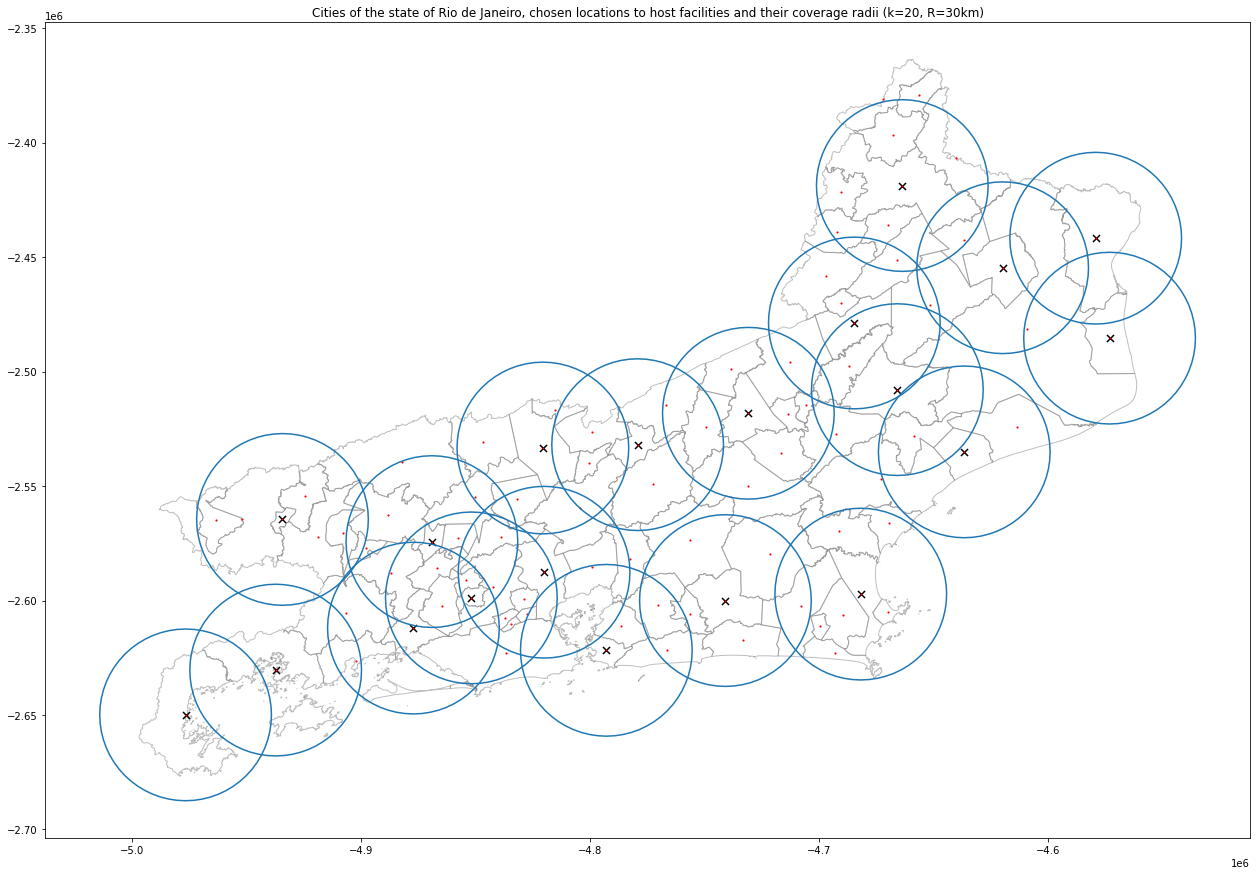

In [145]:
plot_results(geodata_rj, result_open_facilities, result_covered_muns, R)